In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
from random import randint
from operator import *

from ipywidgets import widgets
from IPython.display import display

In [3]:
from flange.actions import *
from flange.combiners import *
from flange.conditions import *
from flange.graphs import *
from flange.locations import *
from flange.roots import *
from flange.runtime import *
from flange.utils import draw

%aimport flange.actions
%aimport flange.combiners
%aimport flange.conditions
%aimport flange.graphs
%aimport flange.locations
%aimport flange.roots
%aimport flange.runtime
%aimport flange.utils

In [4]:
def show(flanglet, graph, size=(8,10)):
    before = graph().copy()
    foci = flanglet.focus(before.copy())
    after = flanglet(before.copy())

    pos = nx.spring_layout(before)
    
    fig = plt.gcf()
    fig.set_figheight(size[0])
    fig.set_figwidth(size[1])
    
    cols = max(len(foci), 6)
    rows = 4
    ax_before = plt.subplot2grid((rows, cols), (0,0), colspan=cols//2, rowspan=3)
    ax_after = plt.subplot2grid((rows, cols), (0,cols//2), colspan=cols//2, rowspan=3)
        
    nx.draw(before, pos=pos, ax=ax_before)
    nx.draw_networkx_labels(before, pos=pos, ax=ax_before)

    for (i, sub) in enumerate(foci):
        ax_select = plt.subplot2grid((rows, cols), (3, i))
        nx.draw(sub, pos=pos, ax=ax_select)
        nx.draw_networkx_labels(sub, pos=pos, ax=ax_select)

    nx.draw(after, pos=pos, ax=ax_after)
    nx.draw_networkx_labels(after, pos=pos, ax=ax_after)
    
    return fig

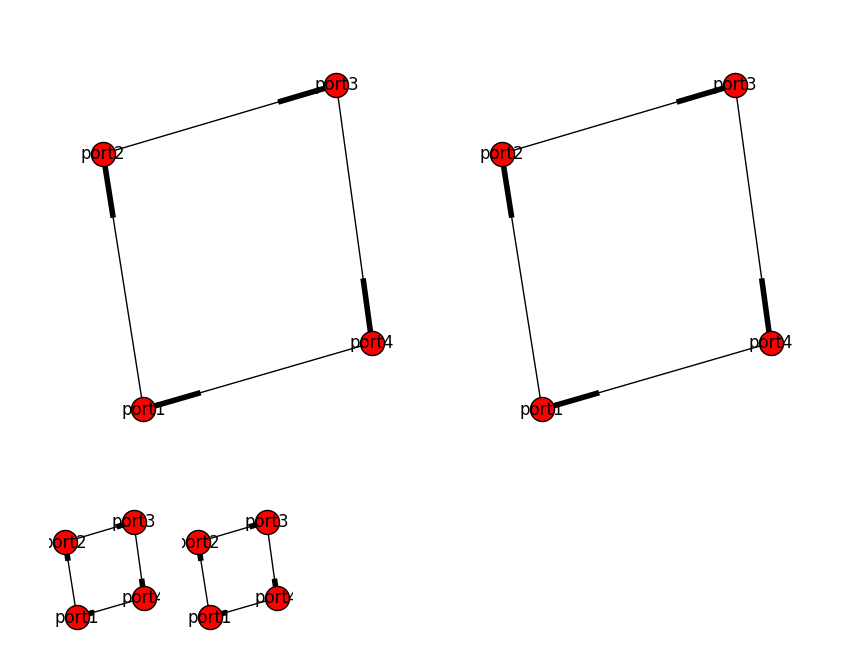

In [5]:
fig = show(rule(lambda x: x, lambda x:x), graph("ring"))

In [ ]:
#assert place firewall on group A in G
#aasert place 10mb path between path(CREST MSU from G)

In [6]:
ab_ring = nx.DiGraph()
ab_ring.add_nodes_from(["A1", "A2", "A3", "A4", "A5", "B1", "B2", "B3"])
ab_ring.add_edges_from([("A1", "A2"), ("A2", "A3"), ("A3", "B1"), 
                        ("B1", "A4"), 
                        ("A4", "B2"), ("B2", "B3"), ("B3", "A5"),
                       ("A5", "A1")])

In [91]:
class collect(FlangeTree):
    """Gather nodes that pass a predcate into a hyper-node.
    
    predicate -- Return a list of node names to compress together
    label -- Name for the node representing all combined nodes
    
    TODO: Inbound edge properties (are they copied?  aggregated? modified?)
    """
    
    def __init__(self, predicate, label="*"):
        self.predicate = predicate
        self.label = label

    def __call__(self, graph):
        group_nodes = self.predicate(graph)
        stable_nodes = [node for node in graph.nodes() if node not in group_nodes]
        
        synth = graph.subgraph(stable_nodes)
        synth.add_node(self.label)
        
        outbound = list(graph.out_edges_iter(group_nodes))
        inbound = list(graph.in_edges_iter(group_nodes))

        for (start, end) in inbound:
            if not synth.has_edge(start, self.label) \
                and start not in group_nodes:
                synth.add_edge(start, self.label, **graph.get_edge_data(start, end))

        for (start, end) in outbound:
            if not synth.has_edge(self.label, end) \
                and end not in group_nodes:
                synth.add_edge(self.label, end, **graph.get_edge_data(start, end))

        return synth




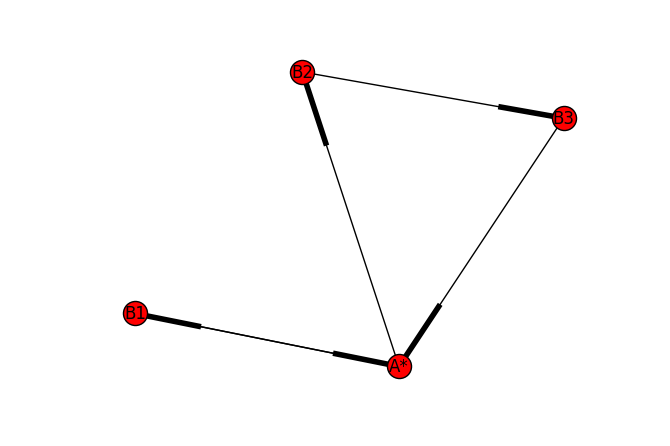

In [92]:
draw(collect(lambda g: [n for n in g.nodes() if n.startswith("A")], "A*")(ab_ring))

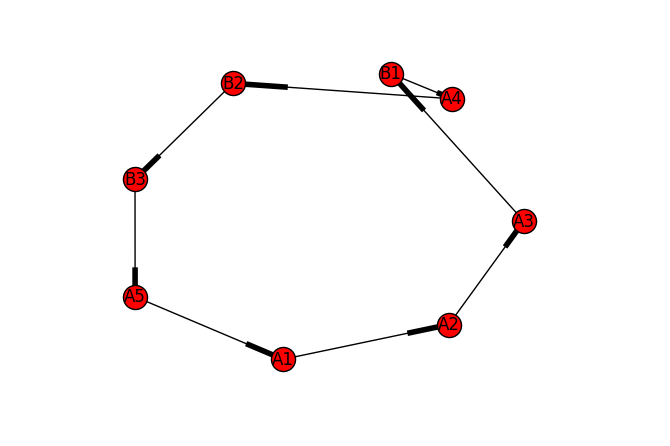

In [86]:
draw(ab_ring)